In [5]:
import os
import numpy as np
from scipy.io import loadmat
import random

# 指定文件夹路径
download_save_path = 'E:/Dataset/wind_shear/Data_Download'
exception_save_path = '../Dataset/Exception_Data'

# 获取文件夹下的所有文件名称
download_folder_names = [item for item in os.listdir(download_save_path) if os.path.isdir(os.path.join(download_save_path, item))]
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
download_folder_paths = [os.path.join(download_save_path, item) for item in download_folder_names]
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

In [6]:
# give the preset classification of variables
group_names_list = ["mechanism", "power", "control", "external", "recorder", "unclassified"]
group_lens_dict = {}

var_group_mechanism = ["AIL_1", "AIL_2", "FLAP", "ELEV_1", "ELEV_2", "RUDD", "SPL_1", "SPL_2", "SPLG", "SPLY", "ABRK", "BPGR_1", "BPGR_2", "BPYR_1", "BPYR_2", "MSQT_1", "MSQT_2", "NSQT", "BLV", "CALT", "PACK", "WOW", 
                       "AOA1", "AOA2", "GLS", "PTCH", "ROLL", 
                       "TH", "MH", "TAS", "CASM", "GS", "IVV",
                       "VRTG", "LATG", "LONG", "FPAC", "CTAC"]
var_group_power = ["N2_1", "N2_2", "N2_3", "N2_4",
                   "ECYC_1", "ECYC_2", "ECYC_3", "ECYC_4", "EHRS_1", "EHRS_2", "EHRS_3", "EHRS_4", "VIB_1", "VIB_2", "VIB_3", "VIB_4", "FADS", "HYDG", "HYDY",
                   "N1_1", "N1_2", "N1_3", "N1_4", "N1T", "FF_1", "FF_2", "FF_3", "FF_4", "FQTY_1", "FQTY_2", "FQTY_3", "FQTY_4", "OIP_1", "OIP_2", "OIP_3", "OIP_4", "OIT_1", "OIT_2", "OIT_3", "OIT_4", "OIPL", "EGT_1", "EGT_2", "EGT_3", "EGT_4",
                   "LGDN", "LGUP"]
var_group_control = ["CRSS", "HDGS", "A_T", "APFD", "DFGS", "FGC3", "PUSH", "PTRM", "TCAS",
                     "ILSF", "RUDP", "CCPC", "CCPF", "CWPC", "CWPF", "PLA_1", "PLA_2", "PLA_3", "PLA_4",
                     "SNAP", "TMODE", "EAI", "TAI", "WAI_1", "WAI_2", 
                     "APUF", "FADF", "FIRE_1", "FIRE_2", "FIRE_3", "FIRE_4", "GPWS", "MW", "POVT", "SHKR", "SMOK", "TOCW"]
var_group_external = ["ALT", "ALTR", "WS", "WD", "PI", "PS", "PT", "SAT", "TAT",
                      "DA", "TRK", "TRKM", "LOC", "LATP", "LONP"]
var_group_recorder = ["DWPT", "PH", 
                     "ACMT", "FRMC", "GMT_HOUR", "GMT_MINUTE", "GMT_SEC"]
var_group_unclassified = ["ATEN", "EVNT", "HF1", "HF2", "VHF1", "VHF2", "VHF3", "LMOD", "VMODE", "MACH", "MNS", "MRK", "N1C", "N1CO", "SMKB", "VAR_1107", "VAR_2670", "VAR_5107", "VAR_6670"]

var_groups_dict = {"mechanism": var_group_mechanism, "power": var_group_power, "control": var_group_control, "external": var_group_external, "recorder": var_group_recorder, "unclassified": var_group_unclassified}
for group_name, var_group in var_groups_dict.items():
    group_lens_dict[group_name] = len(var_group)
    print(f"{group_name}: {len(var_group)}")
print(f"\n{sum(group_lens_dict.values())} variables in total")

# 查找给定总序数对应的变量名称
def find_var_name(idx, var_dict):
    count = 0
    group_lens_dict = {}
    for group_name, var_group in var_dict.items():
        group_lens_dict[group_name] = len(var_group)
    for group_name, var_group in var_dict.items():
        if count + group_lens_dict[group_name] > idx:
            return group_name, var_group[idx - count]
        else:
            count += group_lens_dict[group_name]

# 查找给定变量名称对应的总序数
def find_var_idx(var_name, var_dict):
    count = 0
    for var_list in var_dict.values():
        if var_name in var_list:
            count += var_list.index(var_name)
            return(count)
        else:
            count += len(var_list)

mechanism: 38
power: 47
control: 37
external: 15
recorder: 7
unclassified: 19

163 variables in total


In [11]:
# 进行pca分析
from sklearn.decomposition import PCA
from scipy.io import loadmat
import os
import numpy as np

# 设置工作目录
download_folder_name = 'Tail_652_1'

# 设置结果存储目录
pca_save_path = '../result/variable_evaluate/pca'
if not os.path.exists(pca_save_path):
    os.mkdir(pca_save_path)

# 初始化pca结果存储array
ev_ratio_array = []
PCs_array = []

for mat_name in os.listdir(os.path.join(download_save_path, download_folder_name)):
    # 载入mat文件
    mat = loadmat(os.path.join(download_save_path, download_folder_name, mat_name))
    # 将mat文件整理成(163, )的array
    wshr_data = mat["WSHR"][0][0][0]
    sampling_data_array = []
    for var_list in var_groups_dict.values():
        for var_name in var_list:
            var_data, var_rate = mat[var_name][0][0][0], mat[var_name][0][0][1][0][0]
            # 对每个变量按照rate进行下采样或过采样，对长为n+1的数据，抓取前n个全变量为输入，后n个有缺变量为输出
            if var_rate == 1:
                sampling_data = var_data
            elif var_rate > 1: # 进行下采样
                sampling_data = random.sample(var_data.tolist(), k=len(wshr_data))
            else:
                sampling_data = random.choices(var_data, k=len(wshr_data))
            sampling_data_array.append(sampling_data)
    summary_data_array = np.squeeze(np.array(sampling_data_array)).T
    # print(summary_data_array.shape)

    # 创建一个PCA对象并指定要保留的主成分数量
    # n_components = summary_data_array.shape[0]
    n_components = 50
    pca = PCA(n_components)

    # 对数据集进行PCA
    pca.fit_transform(summary_data_array)

    # 获取主成分的方差解释比例
    explained_variance_ratio = pca.explained_variance_ratio_
    ev_ratio_array.append(explained_variance_ratio)
    # print("解释方差比例：", explained_variance_ratio, "  ----- 总计：", sum(explained_variance_ratio))

    # 获取主成分的特征向量
    components = pca.components_
    PCs_array.append(components)
    # print("主成分特征向量：", components)

    # break

ev_ratio_array = np.array(ev_ratio_array)
PCs_array = np.array(PCs_array)

# 存储结果array
# np.save(os.path.join(pca_save_path, "ev_ratio_array.npy"), ev_ratio_array)
# np.save(os.path.join(pca_save_path, "PCs_array.npy"), PCs_array)

In [15]:
print(np.array(ev_ratio_array).shape)
print(np.array(PCs_array).shape)

(676, 50)
(676, 50, 163)


[0, 1, 2, 3, 4, 5, 6, 7, 13, 22, 23, 74, 77, 81, 82, 92, 95, 96, 97, 98, 119, 122, 123, 127, 128, 139, 140]
156


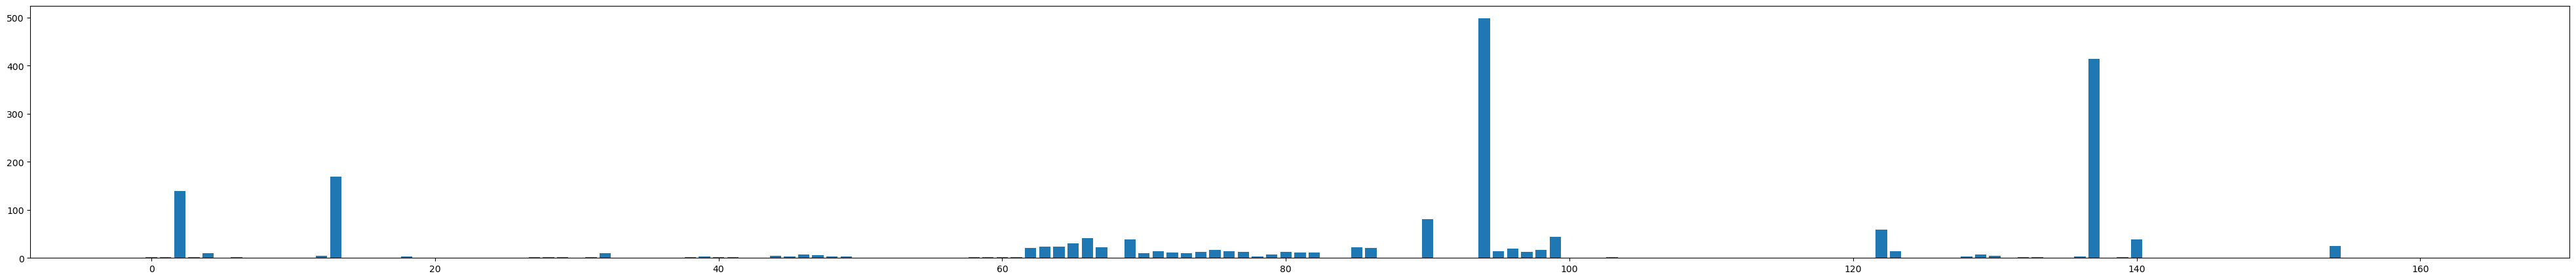

In [24]:
# 筛选关键变量的最小交集和最大并集
import numpy as np
import os
import matplotlib.pyplot as plt

# 读取存储数据
pca_save_path = '../result/variable_evaluate/pca'
ev_ratio_array = np.load(os.path.join(pca_save_path, "ev_ratio_array.npy"))
PCs_array = np.load(os.path.join(pca_save_path, "PCs_array.npy"))

# 规定主成分方差解释比例阈值，以及变量解释阈值的最小绝对值
PC_threshold = 0.95
var_abs_threshold = 0

# 计算每个mat要保留的主成分数量
PC_num_list = []
primal_ev_ratio_list = []
for ev_ratio_list in ev_ratio_array:
    sum_ev_ratio = 0
    for i, ev_ratio in enumerate(ev_ratio_list):
        if i == 0:
            primal_ev_ratio_list.append(ev_ratio)
        sum_ev_ratio += ev_ratio
        if sum_ev_ratio >= PC_threshold:
            PC_num_list.append(i+1)
            break
# print(primal_ev_ratio_list)

# 初始化变量存在性array和加权存在性矩阵
var_exist_array = np.zeros((len(PC_num_list), 163))
var_weighted_exist_array = np.zeros((len(PC_num_list), 163))

# 更新每个mat中主成分中存在的变量
primal_pc_list = []
for i, PC_array in enumerate(PCs_array):
    # threshold_PC_array = PC_array[:PC_num_list[i]]
    for k, PC in enumerate(PC_array[:PC_num_list[i]]):
        # 检查第k个主成分中系数绝对值大于threshold的变量
        '''
        方差解释比例低的主成分中的变量系数意义不大，只用其存在性来捕捉哪怕再小的作用
        但是在给变量在各种潜在机制中参与程度进行排序时，将其存在的主成分的总方差解释比例 * minmax归一化后的系数 作为其参与广度的一个metrics
        （这里的minmax归一化是分符号的，如果该变量在主成分中系数为正值，那么就比上最大正值，反之比上最小负值）
        '''
        if k == 0:
            primal_pc_list.append(PC)
        exist_idx = np.where(abs(PC) > var_abs_threshold)[0]
        var_exist_array[i][exist_idx] = 1
        weighted_ratio_list = []
        for idx in exist_idx:
            if PC[idx] > 0:
                weighted_ratio_list.append(PC[idx] / max(PC))
            elif PC[idx] < 0:
                weighted_ratio_list.append(PC[idx] / min(PC))
        # print(np.max(weighted_ratio_list))
        var_weighted_exist_array[i][exist_idx] += ev_ratio_array[i][k] * np.array(weighted_ratio_list)

# 存储变量存在性和加权存在性array
np.save(os.path.join(pca_save_path, "var_exist_array.npy"), var_exist_array)
np.save(os.path.join(pca_save_path, "var_weighted_exist_array.npy"), var_weighted_exist_array)

# 查找array中的全1列序数作为关键变量的最小交
'''
如果一个变量在所有mat的主成分中都有贡献，不论贡献多少，至少说明其影响不可忽略
'''
all_ones_cols_list = []
for i in range(var_exist_array.shape[1]):
    if all(element == 1 for element in var_exist_array[:, i]):
        all_ones_cols_list.append(i)
print(all_ones_cols_list) # var_abs_threshold = 0.001没有，0有
'''
('mechanism': 'AIL_1', 'AIL_2', 'FLAP', 'ELEV_1', 'ELEV_2', 'RUDD', 'SPL_1', 'SPL_2', 'BPYR_1', 'AOA1', 'AOA2')
('power': 'OIT_1', 'OIT_4', 'EGT_3', 'EGT_4')
('control': 'PTRM', 'RUDP', 'CCPC', 'CCPF', 'CWPC', 'SHKR')
('external': 'ALT', 'ALTR', 'PS', 'PT')
('recorder': 'ACMT', 'FRMC')
'''

# 查找array中的非全0列序数作为关键变量的最大并
non_zeros_cols_list = []
for i in range(var_exist_array.shape[1]):
    if any(element == 1 for element in var_exist_array[:, i]):
        non_zeros_cols_list.append(i)
print(len(non_zeros_cols_list)) # var_abs_threshold = 0.95下22个，0.8下28个，0.5下32个，0.1下43个，0.05下54个，0.001下109个，0下156个

''' ===== var_threshold = 0.95 ===== [all in]
('mechanism': 'FLAP', 'BPYR_1', 'IVV')
('power': 'ECYC_4', 'FF_1', 'FF_2', 'FF_3', 'FF_4', 'EGT_1', 'EGT_2', 'EGT_4')
('control': 'FGC3', 'ILSF', 'RUDP', 'CCPC', 'CCPF', 'CWPC', 'CWPF')
('external': 'ALT', 'ALTR')
('recorder': 'DWPT', 'FRMC')
'''
''' ===== var_threshold = 0.05 ===== [all in]
('mechanism': 'FLAP', 'ELEV_2', 'BPYR_1', 'TH', 'MH', 'IVV')
('power': 'N2_4', 'ECYC_3', 'ECYC_4', 'EHRS_1', 'EHRS_2', 'EHRS_3', 'EHRS_4', 'N1T', 'FF_1', 'FF_2', 'FF_3', 'FF_4', 'FQTY_1', 'FQTY_2', 'FQTY_4', 
            'OIP_1', 'OIP_2', 'OIP_3', 'OIP_4', 'OIT_1', 'OIT_2', 'OIT_3', 'OIT_4', 'EGT_1', 'EGT_2', 'EGT_3', 'EGT_4')
('control': 'CRSS', 'HDGS', 'FGC3', 'ILSF', 'RUDP', 'CCPC', 'CCPF', 'CWPC', 'CWPF')
('external': 'ALT', 'ALTR', 'WD', 'DA', 'TRK', 'TRKM', 'LONP')
('recorder': 'DWPT', 'FRMC', 'GMT_MINUTE', 'GMT_SEC')
('unclassified': 'MNS')
'''
''' ===== var_threshold = 0 ===== [all out]
('control': 'TCAS', 'WAI_2', 'APUF', 'POVT')
('unclassified': 'VAR_2670', 'VAR_5107', 'VAR_6670')
'''

# 可视化各变量在所有mat中的贡献度
'''
只用变量存在的所有主成分的方差解释比例的加和做metrics的话，大部分均值都在1附近且方差很小
如果用系数/正负极值对方差解释比例进行加权，则大部分均值集中在0但有不少异常值，特别的('control', 'RUDP')和('recorder', 'PH')均值在1附近但方差很大
如果将加权的结果再求和可以得到差异化的结果，这是因为第一主成分中往往会有一两个变量起关键作用，导致其他变量的系数与之相比非常小，以至于加权因子很小。
这使得加权求和的结果可以大致反应该变量一共在多少个数据集中起到关键作用
'''
plt.figure(figsize=(50, 5))
# plt.boxplot(var_weighted_exist_array)
plt.bar(range(var_weighted_exist_array.shape[1]), np.sum(var_weighted_exist_array, axis=0))
plt.show()


[[18429.477379106353], [0.8041099456117021], [0.15432621635422708]]
[499.02, 413.86, 168.75, 139.54, 80.14, 59.3, 40.51, 23.07, 11.81, 0.74]
[('control', 'ILSF')]
[('recorder', 'DWPT')]
[('mechanism', 'BPYR_1')]
[('mechanism', 'FLAP')]
[('control', 'FGC3')]
[('external', 'ALT')]
[('power', 'FQTY_1'), ('power', 'FQTY_4'), ('control', 'CWPF'), ('recorder', 'FRMC')]
[('power', 'FF_1'), ('power', 'FF_2'), ('power', 'FF_3'), ('power', 'FF_4'), ('power', 'FQTY_2'), ('control', 'CRSS'), ('control', 'HDGS'), ('control', 'CCPC'), ('unclassified', 'MNS')]
[('mechanism', 'ELEV_2'), ('mechanism', 'IVV'), ('power', 'EHRS_1'), ('power', 'OIP_1'), ('power', 'OIP_2'), ('power', 'OIP_3'), ('power', 'OIP_4'), ('power', 'OIT_1'), ('power', 'OIT_2'), ('power', 'OIT_3'), ('power', 'OIT_4'), ('power', 'EGT_1'), ('power', 'EGT_2'), ('power', 'EGT_3'), ('power', 'EGT_4'), ('control', 'RUDP'), ('control', 'CCPF'), ('control', 'CWPC'), ('external', 'ALTR'), ('external', 'SAT')]
[('mechanism', 'AIL_1'), ('mechan

d:\coding\Anaconda\Software\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


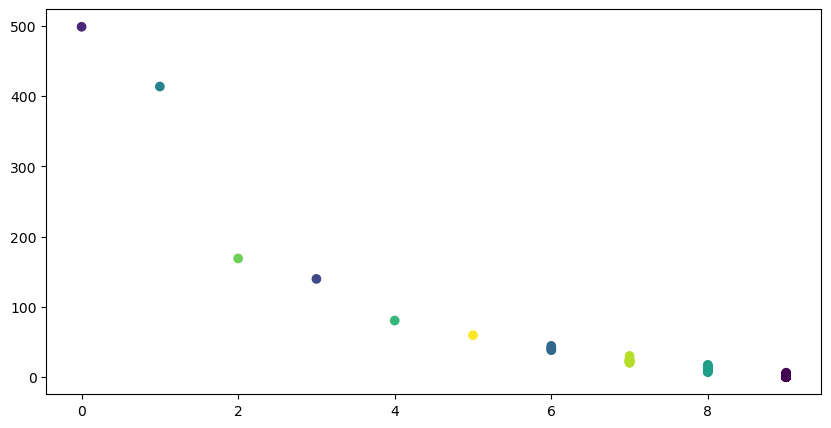

In [61]:
# 对加权求和结果进行聚类
from sklearn.cluster import KMeans
from sklearn import metrics

# for K in range(2, 20):
K = 10
metrics_array = np.sum(var_weighted_exist_array, axis=0).reshape((-1,1))
cluster_labels = KMeans(n_clusters=K, random_state=9, n_init='auto').fit_predict(metrics_array)
np.save(os.path.join(pca_save_path, "cluster_labels.npy"), cluster_labels)

# 打印聚类分数
clustering_metrics_list = [[], [], []]
clustering_metrics_list[0].append(metrics.calinski_harabasz_score(metrics_array, cluster_labels)) # 越大越好
clustering_metrics_list[1].append(metrics.silhouette_score(metrics_array, cluster_labels)) # 越大越好
clustering_metrics_list[2].append(metrics.davies_bouldin_score(metrics_array, cluster_labels)) # 越小越好
print(clustering_metrics_list)

# 输出聚类中心
cluster_centers = []
for k in range(K):
    center = np.mean(metrics_array[cluster_labels == k])
    cluster_centers.append(round(center, 2))
# print(cluster_centers)

# 按照权重大小升序重排cluster_labels
sorted_cluster_centers = sorted(cluster_centers, reverse=True)
print(sorted_cluster_centers)
correspond_idx_list = []
for value in cluster_centers:
    correspond_idx_list.append(sorted_cluster_centers.index(value))
# print(correspond_idx_list)
sorted_cluster_labels = [correspond_idx_list[label] for label in cluster_labels]
# print(sorted_cluster_labels)

# 输出对应变量组
for k in range(K):
    cluster_idx = np.where(np.array(sorted_cluster_labels) == k)[0]
    # cluster_var_name_list = [find_var_name(idx, var_groups_dict) for idx in cluster_idx]
    cluster_var_name_dict = {find_var_name(idx, var_groups_dict): round(metrics_array[idx][0], 2) for idx in cluster_idx}
    if len(cluster_var_name_dict) < 163:
        print(cluster_var_name_dict)
    # print(cluster_var_name_list)

'''
499.02: [('control', 'ILSF')]
413.86: [('recorder', 'DWPT')]
168.75: [('mechanism', 'BPYR_1')]
139.54: [('mechanism', 'FLAP')]
80.14: [('control', 'FGC3')]
59.3: [('external', 'ALT')]
40.51: [('power', 'FQTY_1'), ('power', 'FQTY_4'), 
        ('control', 'CWPF'), 
        ('recorder', 'FRMC')]
23.07: [('power', 'FF_1'), ('power', 'FF_2'), ('power', 'FF_3'), ('power', 'FF_4'), ('power', 'FQTY_2'), 
        ('control', 'CRSS'), ('control', 'HDGS'), ('control', 'CCPC'), 
        ('unclassified', 'MNS')]
11.81: [('mechanism', 'ELEV_2'), ('mechanism', 'IVV'), 
        ('power', 'EHRS_1'), ('power', 'OIP_1'), ('power', 'OIP_2'), ('power', 'OIP_3'), ('power', 'OIP_4'), ('power', 'OIT_1'), ('power', 'OIT_2'), ('power', 'OIT_3'), ('power', 'OIT_4'), 
            ('power', 'EGT_1'), ('power', 'EGT_2'), ('power', 'EGT_3'), ('power', 'EGT_4'), 
        ('control', 'RUDP'), ('control', 'CCPF'), ('control', 'CWPC'), 
        ('external', 'ALTR'), ('external', 'SAT')]
0.74: [ ('mechanism', 'AIL_1'), ('mechanism', 'AIL_2'), ('mechanism', 'ELEV_1'), ('mechanism', 'RUDD'), ('mechanism', 'SPL_1'), ('mechanism', 'SPL_2'), ('mechanism', 'SPLG'), ('mechanism', 'SPLY'), 
            ('mechanism', 'ABRK'), ('mechanism', 'BPGR_1'), ('mechanism', 'BPGR_2'), ('mechanism', 'BPYR_2'), ('mechanism', 'MSQT_1'), ('mechanism', 'MSQT_2'), ('mechanism', 'NSQT'), 
            ('mechanism', 'BLV'), ('mechanism', 'CALT'), ('mechanism', 'PACK'), ('mechanism', 'WOW'), 
            ('mechanism', 'AOA1'), ('mechanism', 'AOA2'), ('mechanism', 'GLS'), ('mechanism', 'PTCH'), ('mechanism', 'ROLL'), ('mechanism', 'TH'), ('mechanism', 'MH'), 
            ('mechanism', 'TAS'), ('mechanism', 'CASM'), ('mechanism', 'GS'), ('mechanism', 'VRTG'), ('mechanism', 'LATG'), ('mechanism', 'LONG'), ('mechanism', 'FPAC'), ('mechanism', 'CTAC'), 
        ('power', 'N2_1'), ('power', 'N2_2'), ('power', 'N2_3'), ('power', 'N2_4'), ('power', 'ECYC_1'), ('power', 'ECYC_2'), ('power', 'ECYC_3'), ('power', 'ECYC_4'), 
            ('power', 'EHRS_2'), ('power', 'EHRS_3'), ('power', 'EHRS_4'), ('power', 'VIB_1'), ('power', 'VIB_2'), ('power', 'VIB_3'), ('power', 'VIB_4'), 
            ('power', 'FADS'), ('power', 'HYDG'), ('power', 'HYDY'), ('power', 'N1_1'), ('power', 'N1_2'), ('power', 'N1_3'), ('power', 'N1_4'), ('power', 'N1T'), 
            ('power', 'FQTY_3'), ('power', 'OIPL'), ('power', 'LGDN'), ('power', 'LGUP'), 
        ('control', 'A_T'), ('control', 'APFD'), ('control', 'DFGS'), ('control', 'PUSH'), ('control', 'PTRM'), ('control', 'TCAS'), 
            ('control', 'PLA_1'), ('control', 'PLA_2'), ('control', 'PLA_3'), ('control', 'PLA_4'), ('control', 'SNAP'), ('control', 'TMODE'), ('control', 'EAI'), ('control', 'TAI'), 
            ('control', 'WAI_1'), ('control', 'WAI_2'), ('control', 'APUF'), ('control', 'FADF'), ('control', 'FIRE_1'), ('control', 'FIRE_2'), ('control', 'FIRE_3'), ('control', 'FIRE_4'), 
            ('control', 'GPWS'), ('control', 'MW'), ('control', 'POVT'), ('control', 'SHKR'), ('control', 'SMOK'), ('control', 'TOCW'), 
        ('external', 'WS'), ('external', 'WD'), ('external', 'PI'), ('external', 'PS'), ('external', 'PT'), ('external', 'TAT'), ('external', 'DA'), ('external', 'TRK'), ('external', 'TRKM'), 
            ('external', 'LOC'), ('external', 'LATP'), ('external', 'LONP'), 
        ('recorder', 'PH'), ('recorder', 'ACMT'), ('recorder', 'GMT_HOUR'), ('recorder', 'GMT_MINUTE'), ('recorder', 'GMT_SEC'), 
        ('unclassified', 'ATEN'), ('unclassified', 'EVNT'), ('unclassified', 'HF1'), ('unclassified', 'HF2'), 
            ('unclassified', 'VHF1'), ('unclassified', 'VHF2'), ('unclassified', 'VHF3'), ('unclassified', 'LMOD'), ('unclassified', 'VMODE'), 
            ('unclassified', 'MACH'), ('unclassified', 'MRK'), ('unclassified', 'N1C'), ('unclassified', 'N1CO'), ('unclassified', 'SMKB'), 
            ('unclassified', 'VAR_1107'), ('unclassified', 'VAR_2670'), ('unclassified', 'VAR_5107'), ('unclassified', 'VAR_6670')]
'''

plt.figure(figsize = (10, 5))
plt.scatter(sorted_cluster_labels, metrics_array[:, 0], c=cluster_labels)
plt.show()

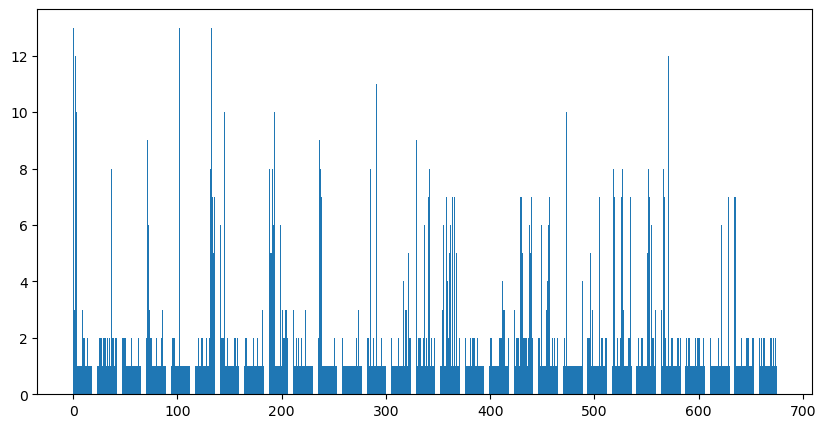

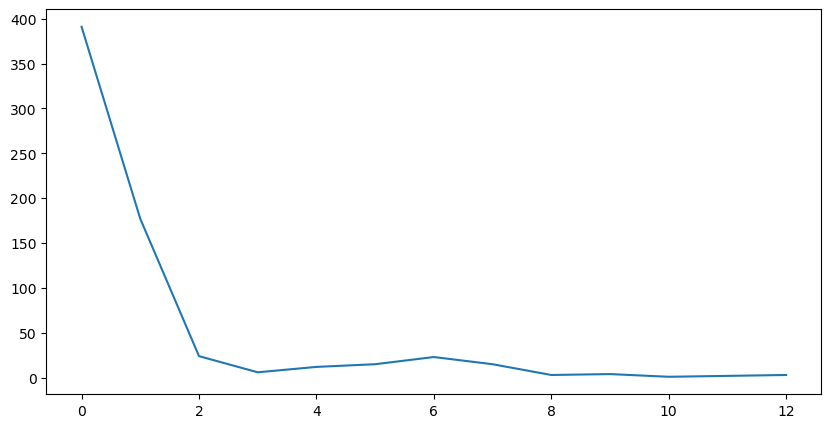

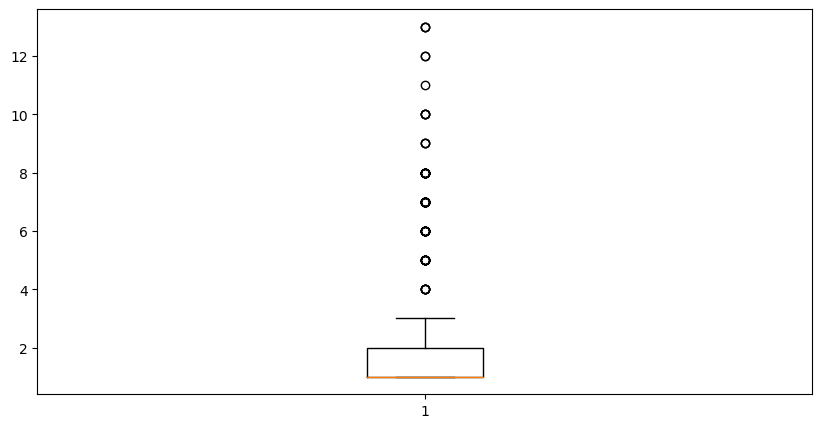

In [48]:
# 打印各mat中主成分数量分布
import matplotlib.pyplot as plt

download_folder_name = 'Tail_652_1'
mat_names = os.listdir(os.path.join(download_save_path, download_folder_name))

plt.figure(figsize=(10, 5))
plt.bar(range(len(mat_names)), PC_num_list)
# plt.xticks(mat_names)
plt.show()

PC_fre_list = [len(np.where(np.array(PC_num_list) == i)[0]) for i in range(1, max(PC_num_list) + 1)]
plt.figure(figsize=(10, 5))
plt.plot(PC_fre_list)
# plt.xticks(mat_names)
plt.show()

plt.figure(figsize=(10, 5))
plt.boxplot(PC_num_list)
plt.show()

In [36]:
for idx in range(163):
    if idx not in non_zeros_cols_list:
        print(find_var_name(idx, var_groups_dict))

('control', 'TCAS')
('control', 'WAI_2')
('control', 'APUF')
('control', 'POVT')
('unclassified', 'VAR_2670')
('unclassified', 'VAR_5107')
('unclassified', 'VAR_6670')
